### Train a Deep MLP on the MNIST Dataset and see if we can get over 98% precision. 

- Try searching for optimal learning rate by growing it exponentially, plotting the loss and finding the point where the loss shoots up.

- Try adding saves, checkpoints and plotting the learning curves using TensorBoard. 

In [58]:
import tensorflow as tf
from tensorflow import keras
import os
import time
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np

In [26]:
print(tf.__version__)
print(keras.__version__)


2.11.0
2.11.0


In [27]:
# Get the data
(X_train_complete, Y_train_complete), (X_test, Y_test) = keras.datasets.mnist.load_data()

# create the validation set
X_train, X_valid = X_train_complete[5000:] / 250, X_train_complete[:5000] / 250 # Gradient descent requires that we scale. 
Y_train, Y_valid = Y_train_complete[5000:], Y_train_complete[:5000]

X_valid.shape

(5000, 28, 28)

### Building a Standard Model

In [28]:
# Building a standard_model using the sequential API
standard_model = keras.models.Sequential()

standard_model.add(keras.layers.Flatten(input_shape=[28, 28]))
standard_model.add(keras.layers.Dense(300, activation='relu'))
standard_model.add(keras.layers.Dense(100, activation='relu'))
standard_model.add(keras.layers.Dense(10, activation='softmax')) # Softmax as we are classifying, 10 because there are 10 classes. 

standard_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Looking at the weights and biases.

first_hidden = standard_model.layers[1]
weights, biases = first_hidden.get_weights()
weights.shape
biases.shape

(300,)

In [30]:
# Compiling the model.

standard_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=[keras.metrics.SparseCategoricalAccuracy()]) # Using sparse categorical cross entropy as we are using integer labels not one hot encoding labels. 



### Creating Callbacks and TensorBoard Log Directories for Training. 

In [31]:
# TensorBoard associated code. 
root_log_dir = os.path.join(os.curdir, "logs")

# Create a specific sub directory to store the run data
def current_run_log_dir():
    '''Creates a current run directory'''
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_log_dir, run_id)


my_logs = current_run_log_dir()

In [33]:
# Creating the callbacks
saver_cb = keras.callbacks.ModelCheckpoint("standard_mnist_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensor_board_cb = keras.callbacks.TensorBoard(my_logs)

### Training

In [34]:
history = standard_model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), callbacks=[saver_cb, early_stopping_cb, tensor_board_cb])

Epoch 1/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5982 - sparse_categorical_accuracy: 0.8442 - val_loss: 0.3076 - val_sparse_categorical_accuracy: 0.9148
Epoch 2/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2865 - sparse_categorical_accuracy: 0.9175 - val_loss: 0.2401 - val_sparse_categorical_accuracy: 0.9322
Epoch 3/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2354 - sparse_categorical_accuracy: 0.9322 - val_loss: 0.2065 - val_sparse_categorical_accuracy: 0.9404
Epoch 4/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2020 - sparse_categorical_accuracy: 0.9419 - val_loss: 0.1774 - val_sparse_categorical_accuracy: 0.9520
Epoch 5/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1765 - sparse_categorical_accuracy: 0.9495 - val_loss: 0.1587 - val_sparse_categorical_accuracy: 0.9570
Epoch 6/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1563 -

In [36]:
# Creating and connecting to the server
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4008), started 1:14:46 ago. (Use '!kill 4008' to kill it.)

### Standard Model Testing

In [38]:
standard_model = keras.models.load_model("standard_mnist_model.h5")

standard_model.evaluate(X_test, Y_test)

313/313 [==============================] - 0s 548us/step - loss: 13.4880 - sparse_categorical_accuracy: 0.9753


[13.487970352172852, 0.9753000140190125]

Using our standard model, we got an accuracy of 97%. Lets go and tune our model to improve this score to above 98%. There are several things we can tune with deep neural networks. 

- The number of layers.
- The number of nodes in a layer. 
- The learning rate. 
- The batch size. 
- The optimizer.
- The activation function. 
- The initialized weights. 

In [88]:
keras.backend.clear_session()

### Altering The Learning Rate

- The standard LearningRateScheduler does not allow us to change when we implement our learning rate changes so we are going to use the custom one from the workbook.

In [80]:
class LearningRateIncreaser(keras.callbacks.Callback):
    ''' Increases the learning rate by a %.'''
    
    def __init__(self, increase):
        self.increase = increase
        self.learning_rates = []
        self.losses = []
    
    def on_batch_end(self, batch, logs):
        ''' Stores the current learning rate and loss, sets the new learning rate.'''
        self.learning_rates.append(keras.backend.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs['loss'])
        keras.backend.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.increase)



In [89]:
# Creating another model where we will tune the learning rate. 

lr_tuned_model = keras.models.Sequential()

lr_tuned_model.add(keras.layers.Flatten(input_shape=[28, 28]))
lr_tuned_model.add(keras.layers.Dense(200, activation='relu'))
lr_tuned_model.add(keras.layers.Dense(100, activation='relu'))
lr_tuned_model.add(keras.layers.Dense(10, activation='softmax'))

lr_tuned_model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=['accuracy']) # Starting really small. 
lr_tuner_cb = LearningRateIncreaser(increase=1.005) # Increasing by 0.5% each iteration. 

1719/1719 [==============================] - 2s 1ms/step - loss: nan - accuracy: 0.5851 - val_loss: nan - val_accuracy: 0.0958
5.2636895


Text(0, 0.5, 'Loss')

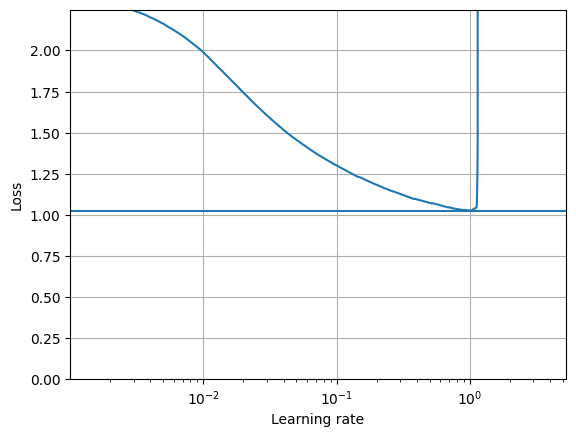

In [90]:
history = lr_tuned_model.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid), callbacks=[lr_tuner_cb])

print(max(lr_tuner_cb.learning_rates))

plt.plot(lr_tuner_cb.learning_rates, lr_tuner_cb.losses)
plt.gca().set_xscale('log')
plt.hlines(min(lr_tuner_cb.losses), min(lr_tuner_cb.learning_rates), max(lr_tuner_cb.learning_rates))
plt.axis([min(lr_tuner_cb.learning_rates), max(lr_tuner_cb.learning_rates), 0, lr_tuner_cb.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")
